## Import statements

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import random
from collections import Counter

## Loading the data

In [2]:
# Load the Barabási-Albert graph data
b_node_file = "barabasi_100_nodes.csv"
b_edge_file = "barabasi_100_edges.csv"

nodes = pd.read_csv(b_node_file)
edges = pd.read_csv(b_edge_file)

# Graph
BG = nx.from_pandas_edgelist(edges, source='source', target='target')
BG.add_nodes_from(nodes['id'])

# Load the Erdos-Renyi graph data
e_node_file = "erdos_100_nodes.csv"
e_edge_file = "erdos_100_edges.csv"

nodes = pd.read_csv(e_node_file)
edges = pd.read_csv(e_edge_file)

# Graph
EG = nx.from_pandas_edgelist(edges, source='source', target='target')
EG.add_nodes_from(nodes['id'])


# Load the Facebook pages graph data
fb_node_file = "fb-pages-food_nodes.csv"
fb_edge_file = "fb-pages-food_edges.csv"

nodes = pd.read_csv(fb_node_file)
edges = pd.read_csv(fb_edge_file)

# Graph
fbG = nx.from_pandas_edgelist(edges, source='source', target='target')
fbG.add_nodes_from(nodes['new_id'])

# Load data
edges = pd.read_csv("txs_edgelist.csv")

# Adjust column names here based on what the CSV shows
G_full = nx.from_pandas_edgelist(edges, source='txId1', target='txId2', create_using=nx.Graph())

# Sample 500 nodes
sub_nodes = list(G_full.nodes)[:500]
BcG = G_full.subgraph(sub_nodes).copy()

## Functions for influence propagation

In [3]:
def linear_threshold(sfg, seeds, threshold_range=(0.0, 1.0)):
    """
    Simulate the Linear Threshold Model.
    G: NetworkX graph
    seeds: initial active nodes (seed nodes)
    threshold_range: range of thresholds for each node
    Returns the set of activated nodes.
    """
    # Assign random thresholds to each node
    thresholds = {node: np.random.uniform(*threshold_range) for node in sfg.nodes()}
    activated = set(seeds)
    while True:
        new_activated = set()
        for node in sfg.nodes():
            if node not in activated:
                neighbors = list(sfg.neighbors(node))
                if not neighbors:
                    continue
                active_neighbors = sum(1 for neighbor in neighbors if neighbor in activated)
                if (active_neighbors / len(neighbors)) >= thresholds[node]:
                    new_activated.add(node)
        if not new_activated:
            break
        activated.update(new_activated)
    return activated

def Independent_Cascade_model(G, seeds, influence_probabilities):
    activated = set(seeds)
    prev_round_activated = activated.copy()
    ctr = 0
    node_idx_dict = {x: idx for idx, x in enumerate(G.nodes)}
    while True:
        ctr += 1
        new_activated = set()
        modified_influence_probabilities = np.delete(influence_probabilities,[node_idx_dict[x] for x in activated],axis=1)
        for node in prev_round_activated:
            neighbors = set(G.neighbors(node))-activated
            node_influence_probabilities = modified_influence_probabilities[node_idx_dict[node],:]
            node_influence_probabilities = node_influence_probabilities[node_influence_probabilities!=0]
            
            new_activated = new_activated.union(set(list(np.array(list(neighbors))[np.random.uniform(size=len(neighbors))<node_influence_probabilities])))

        activated.update(new_activated)
        if not new_activated:
          break

        prev_round_activated = new_activated

    return activated

def Uniform_influence_prob(G, p):
    return p*(nx.adjacency_matrix(G).toarray())

def Weighted_cascade(G):
    adj_mat = nx.adjacency_matrix(G).toarray()
    return np.divide(adj_mat.T,np.sum(adj_mat,axis=1)).T

## Greedy Algorithm

In [4]:
def greedy_optimizer(G, k, spread_fn):
    selected = []
    for _ in range(k):
        best_node = None
        best_spread = -1
        for node in G.nodes:
            if node in selected:
                continue
            spread = spread_fn(G, selected + [node])
            if spread > best_spread:
                best_spread = spread
                best_node = node
        selected.append(best_node)
    return selected

# Spread Estimation Functions
def estimate_spread_ic(G, seeds, simulations=50):
    return np.mean([len(Independent_Cascade_model(G, seeds, influence_probabilities)) for _ in range(simulations)])

def estimate_spread_lt(G, seeds, simulations=50):
    return np.mean([len(linear_threshold(G, seeds)) for _ in range(simulations)])

## Reverse Influence Sampling Algorithm

In [5]:
def get_RRS(Graph,p):   
    """
    Inputs: Graph:  NetworkX graph
            p:  Disease propagation probability
    Return: A random reverse reachable set expressed as a list of nodes
    """

    G = list(Graph.edges())
    G = pd.DataFrame(G, columns=['source', 'target'])
    
    # Step 1. Select random source node
    source = random.choice(np.unique(G['source']))
    
    # Step 2. Get an instance of g from G by sampling edges  
    g = G.copy().loc[np.random.uniform(0,1,G.shape[0]) < p]

    # Step 3. Construct reverse reachable set of the random source node
    new_nodes, RRS0 = [source], [source]   
    while new_nodes:
        
        # Limit to edges that flow into the source node
        temp = g.loc[g['target'].isin(new_nodes)]

        # Extract the nodes flowing into the source node
        temp = temp['source'].tolist()

        # Add new set of in-neighbors to the RRS
        RRS = list(set(RRS0 + temp))

        # Find what new nodes were added
        new_nodes = list(set(RRS) - set(RRS0))

        # Reset loop variables
        RRS0 = RRS[:]

    return(RRS)

def Reverse_Influence_Sampling(Graph, percentage_of_nodes,p=0.1,mc=1000):
    """
    Inputs: Graph:  NetworkX graph
            percentage_of_nodes:  Size of seed set
            p:  Disease propagation probability
            mc: Number of RRSs to generate
    Return: A seed set of nodes as an approximate solution to the IM problem
    """
    G = list(Graph.edges())
    G = pd.DataFrame(G, columns=['source', 'target'])
    num_nodes = Graph.number_of_nodes()
    k = int(num_nodes * percentage_of_nodes)
    
    # Step 1. Generate the collection of random RRSs
    # start_time = time.time()
    R = [get_RRS(Graph,p) for _ in range(mc)]

    # Step 2. Choose nodes that appear most often (maximum coverage greedy algorithm)
    # SEED, timelapse = [], []
    SEED = []
    # print(f"Number of RRSs generated: {len(R)}")
    # print(f"Size of seed set: {k}")
    for _ in range(k):
        
        # Find node that occurs most often in R and add to seed set
        flat_list = [item for sublist in R for item in sublist]

        if not flat_list:
            # print("Percentage of nodes: ", percentage_of_nodes)
            # print("No more nodes available to select.")
            # print(f"Final seed set: {sorted(SEED)}")
            break  
        seed = Counter(flat_list).most_common()[0][0]
        SEED.append(int(seed))
        
        # Remove RRSs containing last chosen seed 
        R = [rrs for rrs in R if seed not in rrs]
        
        # Record Time
        # timelapse.append(time.time() - start_time)
    
    return(sorted(SEED))


## CELF Algorithm

In [6]:
def Cost(A,c,node_idx_dict):
    res = 0
    for a in A:
        res += c[node_idx_dict[a]]
    return res

def min_remaining_cost(remaining_nodes,c,node_idx_dict):
    res = np.max(c)
    for a in remaining_nodes:
        res = min(res,c[node_idx_dict[a]])
    return res

def Reward(G,A,num_iterations,propagation_model,Unif_influence_prob=True,influence_prob=0.25):
    Expected_reward = 0
    if propagation_model=="LT":
        for i in range(num_iterations):
            Expected_reward += len(linear_threshold(G,A)) ### Fill in the third argument here

    elif propagation_model=="IC":
        if Unif_influence_prob:
            Influence_probabilities = Uniform_influence_prob(G,influence_prob)
            # print(1)
            # print(type(Influence_probabilities))
            for i in range(num_iterations):
                Expected_reward += len(Independent_Cascade_model(G,A,Influence_probabilities))

        else:
            # print(0)
            Influence_probabilities = Weighted_cascade(G)
            # print(type(Influence_probabilities))
            for i in range(num_iterations):
                Expected_reward += len(Independent_Cascade_model(G,A,Influence_probabilities))

    Expected_reward /= num_iterations
    return Expected_reward

def Lazy_Forward(G,c,B,num_iterations,propagation_model,Unif_influence_prob=True,influence_prob=0.25):### Need to make sure that cost c has proper index. Check whether the index is the node value itself or should it be computed based on G.nodes (like node_idx_dict in Independent_Cascade_model() function)
    nodes = G.nodes
    node_idx_dict = {x: idx for idx, x in enumerate(G.nodes)}
    num_of_nodes = G.number_of_nodes()
    A = set()
    remaining_nodes = nodes-A
    incremental_reward = {x:-1 for x in nodes}
    init_flag = True
    curr_reward = 0
    # print("remaining_nodes:\n",remaining_nodes)
    index = 0
    while min_remaining_cost(remaining_nodes,c,node_idx_dict)<=B-Cost(A,c,node_idx_dict):
        remaining_nodes = remaining_nodes - set([n for n in remaining_nodes if c[node_idx_dict[n]]>B-Cost(A,c,node_idx_dict)])
        # print("iteration: ",index)
        # index += 1
        # print("remaining_nodes:\n",remaining_nodes)
        if init_flag:
            for s in remaining_nodes:
                incremental_reward[s] = (Reward(G,A|set([s]),num_iterations,propagation_model,Unif_influence_prob,influence_prob)-curr_reward)/c[node_idx_dict[s]]

            init_flag = False

        else:
            keys_list = list(incremental_reward.keys())
            for idx in range(len(keys_list)):
                incremental_reward[keys_list[idx]] = (Reward(G,A|set([keys_list[idx]]),num_iterations,propagation_model,Unif_influence_prob,influence_prob)-curr_reward)/c[node_idx_dict[s]]
                if idx<len(keys_list)-1 and incremental_reward[keys_list[idx]]>incremental_reward[keys_list[idx+1]]:
                    break

        incremental_reward = dict(sorted(incremental_reward.items(), key=lambda item: item[1], reverse=True))
        print(f"size: {len(incremental_reward)}")
        print("incremental reward,\n",{key:vals*c[node_idx_dict[key]] for key, vals in incremental_reward.items()})
        print(f"curr_reward: {curr_reward}")
        max_incremental_reward_node = list(incremental_reward.keys())[0]
        A = A|set([max_incremental_reward_node])
        curr_reward = curr_reward + incremental_reward[max_incremental_reward_node]*c[node_idx_dict[max_incremental_reward_node]]
        remaining_nodes = remaining_nodes-set([max_incremental_reward_node])
        incremental_reward.pop(max_incremental_reward_node)
        # print(f"A: {A}")
        # print(f"curr_reward: {curr_reward}")

    return A, curr_reward

def CELF(G, costs, percentage_of_nodes,num_iterations,propagation_model,Unif_influence_prob=True,influence_prob=0.25):
    max_cost = int(G.number_of_nodes()*percentage_of_nodes/100)
    A_UC, R_UC = Lazy_Forward(G,np.ones(G.number_of_nodes()),max_cost,num_iterations,propagation_model,Unif_influence_prob,influence_prob)
    A_CB, R_CB = Lazy_Forward(G,costs,max_cost,num_iterations,propagation_model,Unif_influence_prob,influence_prob)

    if R_UC>R_CB:
        A_opt, R_opt =  A_UC, R_UC

    else:
        A_opt, R_opt = A_CB, R_CB

    return A_opt, R_opt, R_CB


## Baseline Algorithms

In [7]:
def Uniform_Sampling(G, percentage_of_nodes):
    k = int((percentage_of_nodes/100)*G.number_of_nodes())
    seed_nodes = np.random.choice(G.nodes,size=k,replace=False)
    return seed_nodes

def Degree_Centrality(G,percentage_of_nodes):
    k = int((percentage_of_nodes/100)*G.number_of_nodes())
    degree_dict = dict(G.degree())
    sorted_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
    seed_nodes = [node for node, _ in sorted_nodes[:k]]
    return seed_nodes

def Eigen_vector_Centrality(G,percentage_of_nodes):
    k = int((percentage_of_nodes/100)*G.number_of_nodes())
    eigvec_centrality = nx.eigenvector_centrality(G)
    sorted_nodes = sorted(eigvec_centrality.items(), key=lambda x: x[1], reverse=True)
    seed_nodes = [node for node, _ in sorted_nodes[:k]]
    return seed_nodes

## Example Simulations

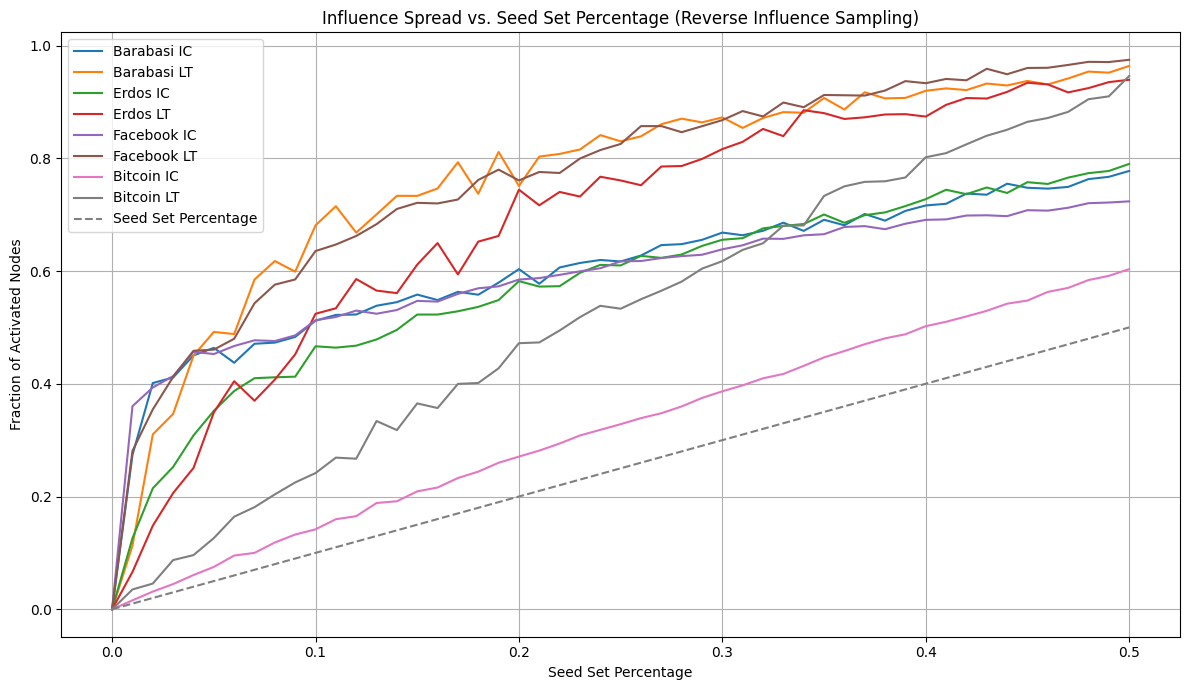

p=0.0 done...
size: 100
incremental reward,
 {7: np.float64(18.6), 3: np.float64(17.84), 0: np.float64(17.65), 2: np.float64(15.56), 26: np.float64(14.74), 4: np.float64(14.52), 11: np.float64(14.15), 15: np.float64(13.13), 6: np.float64(12.94), 5: np.float64(11.37), 1: np.float64(11.22), 12: np.float64(10.6), 19: np.float64(10.53), 18: np.float64(9.27), 10: np.float64(8.81), 8: np.float64(8.45), 27: np.float64(7.96), 48: np.float64(7.91), 39: np.float64(7.76), 9: np.float64(7.7), 53: np.float64(7.21), 41: np.float64(7.19), 31: np.float64(7.1), 46: np.float64(6.95), 29: np.float64(6.83), 16: np.float64(6.79), 34: np.float64(6.75), 49: np.float64(6.62), 13: np.float64(6.52), 28: np.float64(6.48), 21: np.float64(6.27), 51: np.float64(6.2), 57: np.float64(6.06), 36: np.float64(5.97), 40: np.float64(5.87), 17: np.float64(5.68), 92: np.float64(5.68), 44: np.float64(5.67), 56: np.float64(5.53), 43: np.float64(5.48), 25: np.float64(5.45), 62: np.float64(5.44), 87: np.float64(5.4), 32: np.floa

KeyboardInterrupt: 

In [8]:
num_simulations = 100
mean_ic_bg = []
mean_lt_bg = []
mean_ic_eg = []
mean_lt_eg = []
mean_ic_fbg = []
mean_lt_fbg = []
mean_ic_bcg = []
mean_lt_bcg = []
percentages = np.arange(0.00, 0.51, 0.01)

for pct in percentages:
    seed_set_bg = Reverse_Influence_Sampling(BG, pct)
    seed_set_eg = Reverse_Influence_Sampling(EG, pct)
    seed_set_fbg = Reverse_Influence_Sampling(fbG, pct)
    seed_set_bcg = Reverse_Influence_Sampling(BcG, pct)
    results_ic_bg_sim = []
    results_lt_bg_sim = []
    results_ic_eg_sim = []
    results_lt_eg_sim = []
    results_ic_fbg_sim = []
    results_lt_fbg_sim = []
    results_ic_bcg_sim = []
    results_lt_bcg_sim = []
    for sim in range(num_simulations):
        linear_seeds_bg = linear_threshold(BG, seed_set_bg)
        linear_seeds_eg = linear_threshold(EG, seed_set_eg)
        linear_seeds_fbg = linear_threshold(fbG, seed_set_fbg)
        linear_seeds_bcg = linear_threshold(BcG, seed_set_bcg)

        independent_seeds_bg = Independent_Cascade_model(BG, seed_set_bg, Uniform_influence_prob(BG, 0.2))
        independent_seeds_eg = Independent_Cascade_model(EG, seed_set_eg, Uniform_influence_prob(EG, 0.2))
        independent_seeds_fbg = Independent_Cascade_model(fbG, seed_set_fbg, Uniform_influence_prob(fbG, 0.2))
        independent_seeds_bcg = Independent_Cascade_model(BcG, seed_set_bcg, Uniform_influence_prob(BcG, 0.2))

        results_ic_bg_sim.append(len(independent_seeds_bg) / len(BG.nodes()))
        results_lt_bg_sim.append(len(linear_seeds_bg) / len(BG.nodes()))
        results_ic_eg_sim.append(len(independent_seeds_eg) / len(EG.nodes()))
        results_lt_eg_sim.append(len(linear_seeds_eg) / len(EG.nodes()))
        results_ic_fbg_sim.append(len(independent_seeds_fbg) / len(fbG.nodes()))
        results_lt_fbg_sim.append(len(linear_seeds_fbg) / len(fbG.nodes()))
        results_ic_bcg_sim.append(len(independent_seeds_bcg) / len(BcG.nodes()))
        results_lt_bcg_sim.append(len(linear_seeds_bcg) / len(BcG.nodes()))
    # Calculate the mean results for each model across all simulations
    mean_ic_bg.append(np.mean(results_ic_bg_sim))
    mean_lt_bg.append(np.mean(results_lt_bg_sim))
    mean_ic_eg.append(np.mean(results_ic_eg_sim))
    mean_lt_eg.append(np.mean(results_lt_eg_sim))
    mean_ic_fbg.append(np.mean(results_ic_fbg_sim))
    mean_lt_fbg.append(np.mean(results_lt_fbg_sim))
    mean_ic_bcg.append(np.mean(results_ic_bcg_sim))
    mean_lt_bcg.append(np.mean(results_lt_bcg_sim))
    
plt.figure(figsize=(12, 7))
plt.plot(percentages, mean_ic_bg, label='Barabasi IC')
plt.plot(percentages, mean_lt_bg, label='Barabasi LT')
plt.plot(percentages, mean_ic_eg, label='Erdos IC')
plt.plot(percentages, mean_lt_eg, label='Erdos LT')
plt.plot(percentages, mean_ic_fbg, label='Facebook IC')
plt.plot(percentages, mean_lt_fbg, label='Facebook LT')
plt.plot(percentages, mean_ic_bcg, label='Bitcoin IC')
plt.plot(percentages, mean_lt_bcg, label='Bitcoin LT')
plt.plot(percentages, percentages, label='Seed Set Percentage', linestyle='--', color='gray')
plt.xlabel('Seed Set Percentage')
plt.ylabel('Fraction of Activated Nodes')
plt.title('Influence Spread vs. Seed Set Percentage (Reverse Influence Sampling)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the mean results to a CSV file
results_df = pd.DataFrame({
    'Percentage': percentages,
    'Barabasi_IC_RIS': mean_ic_bg,
    'Barabasi_LT_RIS': mean_lt_bg,
    'Erdos_IC_RIS': mean_ic_eg,
    'Erdos_LT_RIS': mean_lt_eg,
    'Facebook_IC_RIS': mean_ic_fbg,
    'Facebook_LT_RIS': mean_lt_fbg,
    'Bitcoin_IC_RIS': mean_ic_bcg,
    'Bitcoin_LT_RIS': mean_lt_bcg
})
results_df.to_csv('RIS_results.csv', index=False)


p_vals = np.linspace(0,50,num=51)
Spread_LT = np.zeros_like(p_vals)
num_iterations_MC_simulations = 100
for idx in range(p_vals.size):
    p = p_vals[idx]
    seed_nodes_CELF_LT, R_LT, _ = CELF(BG,np.ones(BG.number_of_nodes()),percentage_of_nodes=p,num_iterations=num_iterations_MC_simulations,propagation_model="LT")
    # for i in range(num_iterations_MC_simulations):
    #     Spread_LT[idx] += len(linear_threshold(sfg,seed_nodes_CELF_LT))
    #     Spread_IC[idx] += len(Independent_Cascade_model(sfg,seed_nodes_CELF_IC,influence_probabilities=Uniform_influence_prob(sfg,0.25)))

    Spread_LT[idx] = R_LT 
    
    print(f"p={p} done...")

Spread_IC = np.zeros_like(p_vals)
for idx in range(p_vals.size):
    p = p_vals[idx]
    seed_nodes_CELF_IC, R_IC, _ = CELF(BG,np.ones(BG.number_of_nodes()),percentage_of_nodes=p,num_iterations=num_iterations_MC_simulations,propagation_model="IC",Unif_influence_prob=True,influence_prob=0.2)

    Spread_IC[idx] = R_IC
    print(f"p={p} done...")

p_vals = np.linspace(0,50,num=51)
Spread_LT_Barabasi_Rand_Sampling = np.zeros_like(p_vals)
num_iterations_MC_simulations = 100
for idx in range(p_vals.size):
    p = p_vals[idx]
    seed_nodes_Rand_Sample = Uniform_Sampling(BG,p)
    Spread_LT_Barabasi_Rand_Sampling[idx] = Reward(BG,seed_nodes_Rand_Sample,num_iterations=num_iterations_MC_simulations,propagation_model="LT")
    
    print(f"p={p} done...")

Spread_IC_Barabasi_Rand_Sampling = np.zeros_like(p_vals)
p_vals = np.linspace(0,50,num=51)
num_iterations_MC_simulations = 100
for idx in range(p_vals.size):
    p = p_vals[idx]
    seed_nodes_Rand_Sample = Uniform_Sampling(BG,p)
    Spread_IC_Barabasi_Rand_Sampling[idx] = Reward(BG,seed_nodes_Rand_Sample,num_iterations=num_iterations_MC_simulations,propagation_model="IC",Unif_influence_prob=True,influence_prob=0.2)
    
    print(f"p={p} done...")

percentages = list(range(1, 51))
ic_spread_greedy = []
ic_spread_eigen = []
lt_spread_greedy = []
lt_spread_eigen = []
N = BG.number_of_nodes()
influence_probabilities = np.zeros((N, N))
for u, v in BG.edges():
    influence_probabilities[u, v] = 0.2
    influence_probabilities[v, u] = 0.2

for p in percentages:
    k = int((p / 100) * BG.number_of_nodes())

    greedy_seeds = greedy_optimizer(BG, k, lambda G, S: estimate_spread_ic(G, S, simulations=10))
    eigen_seeds = Eigen_vector_Centrality(BG, p)

    ic_spread_greedy.append(estimate_spread_ic(BG, greedy_seeds, simulations=10) / BG.number_of_nodes())
    ic_spread_eigen.append(estimate_spread_ic(BG, eigen_seeds, simulations=10) / BG.number_of_nodes())

    lt_spread_greedy.append(estimate_spread_lt(BG, greedy_seeds, simulations=10) / BG.number_of_nodes())
    lt_spread_eigen.append(estimate_spread_lt(BG, eigen_seeds, simulations=10) / BG.number_of_nodes())

#Plot results
plt.figure(figsize=(12, 6))
plt.plot(percentages, ic_spread_greedy, label="Greedy - IC", marker='o', color='orange')
plt.plot(percentages, ic_spread_eigen, label="Eigenvector - IC", marker='^', color='green')
plt.plot(percentages, lt_spread_greedy, label="Greedy - LT", marker='s', color='blue')
plt.plot(percentages, lt_spread_eigen, label="Eigenvector - LT", marker='d', color='red')
plt.xlabel("Percentage of seed nodes (%)")
plt.ylabel("Fraction of activated nodes")
plt.title("Greedy vs Eigenvector: Influence Spread (IC & LT)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 1. Eigenvector Centrality selection
def Eigen_vector_Centrality(G, percentage_of_nodes):
    k = int((percentage_of_nodes / 100) * G.number_of_nodes())
    eigvec_centrality = nx.eigenvector_centrality(G)
    sorted_nodes = sorted(eigvec_centrality.items(), key=lambda x: x[1], reverse=True)
    return [node for node, _ in sorted_nodes[:k]]

# 2. Fast Independent Cascade model
def fast_ic_model(G, seeds, p=0.2):
    activated = set(seeds)
    new_activated = set(seeds)
    while new_activated:
        next_activated = set()
        for node in new_activated:
            for neighbor in G.neighbors(node):
                if neighbor not in activated and np.random.rand() < p:
                    next_activated.add(neighbor)
        activated.update(next_activated)
        new_activated = next_activated
    return activated

# 3. Linear Threshold model
def linear_threshold(G, seeds, threshold_range=(0.0, 1.0)):
    thresholds = {node: np.random.uniform(*threshold_range) for node in G.nodes()}
    activated = set(seeds)
    while True:
        new_activated = set()
        for node in G.nodes():
            if node not in activated:
                neighbors = list(G.neighbors(node))
                if not neighbors:
                    continue
                active_neighbors = sum(1 for neighbor in neighbors if neighbor in activated)
                if (active_neighbors / len(neighbors)) >= thresholds[node]:
                    new_activated.add(node)
        if not new_activated:
            break
        activated.update(new_activated)
    return activated

# 4. Spread estimation functions
def estimate_spread_ic(G, seeds, simulations=50):
    return np.mean([len(fast_ic_model(G, seeds)) for _ in range(simulations)])

def estimate_spread_lt(G, seeds, simulations=50):
    return np.mean([len(linear_threshold(G, seeds)) for _ in range(simulations)])

# 5. Greedy optimizer
def greedy_optimizer(G, k, spread_fn):
    """
    Inputs:
        G: networkx graph
        k: number of seeds
        spread_fn: function to estimate spread
    Returns:
        selected: list of seed nodes
        final_spread: final reward (spread of selected nodes)
    """
    selected = []
    final_spread = 0
    for _ in range(k):
        best_node = None
        best_spread = -1
        for node in G.nodes:
            if node in selected:
                continue
            spread = spread_fn(G, selected + [node])
            if spread > best_spread:
                best_spread = spread
                best_node = node
        selected.append(best_node)
        final_spread = best_spread # this is the reward for the updated set
    return selected, final_spread
    
# 8. Run analysis and store results
percentages = list(range(1, 51))
results = {
    "Barabasi_IC_Greedy": [],
    "Barabasi_LT_Greedy": [],
    "Barabasi_IC_Eigen": [],
    "Barabasi_LT_Eigen": []
}

for p in percentages:
    k = int((p / 100) * N)
    print(f"Processing {p}%...")

    greedy_seeds_ic, spread_ic = greedy_optimizer(BG, k, lambda G, S: estimate_spread_ic(G, S, simulations=100))
    greedy_seeds_lt, spread_lt = greedy_optimizer(BG, k, lambda G, S: estimate_spread_lt(G, S, simulations=100))
    eigen_seeds = Eigen_vector_Centrality(BG, p)
                                                  
    results["Barabasi_IC_Greedy"].append(spread_ic)
    results["Barabasi_LT_Greedy"].append(spread_lt)
    results["Barabasi_IC_Eigen"].append(estimate_spread_ic(BG, eigen_seeds, simulations=100))
    results["Barabasi_LT_Eigen"].append(estimate_spread_lt(BG, eigen_seeds, simulations=100))